In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# GPD

In [2]:
import geopandas as gpd

import folium
from folium import Marker, GeoJson
from folium.plugins import HeatMap


- anchorage
- berth
- maneuver_zone
- port_boundary

## read_file

### anchorage

<Axes: >

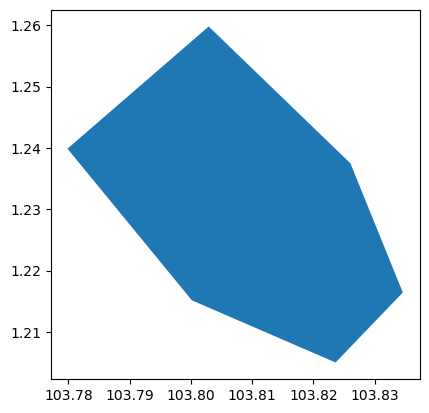

In [3]:
path = "/Users/luozeming/Desktop/1Hackathon/Category A (University Level) - NUS-RightShip Hackathon 2024/PPT_shapefiles/PPT_anchorage.shp"
anchorage = gpd.read_file(path)
anchorage.crs = {'init': 'epsg:4326'}
anchorage.plot()

### berth

<Axes: >

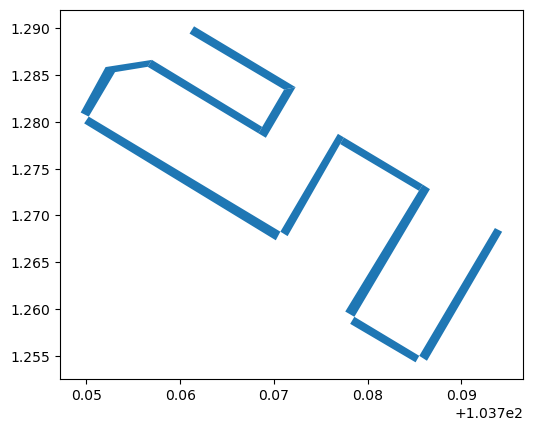

In [4]:
path = "/Users/luozeming/Desktop/1Hackathon/Category A (University Level) - NUS-RightShip Hackathon 2024/PPT_shapefiles/PPT_berths.shp"
berth = gpd.read_file(path)
berth.crs = {'init': 'epsg:4326'}
berth.plot()

### berth_union

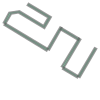

In [5]:
berth_union = berth.geometry.unary_union
berth_union

### maneuver_zone

<Axes: >

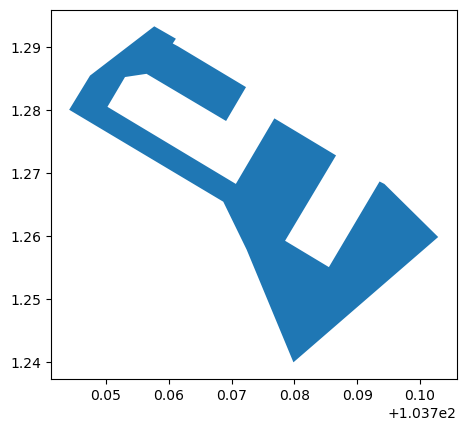

In [6]:
path = "/Users/luozeming/Desktop/1Hackathon/Category A (University Level) - NUS-RightShip Hackathon 2024/PPT_shapefiles/PPT_maneuveringzone.shp"
maneuver_zone = gpd.read_file(path)
maneuver_zone.crs = {'init': 'epsg:4326'}

maneuver_zone.plot()

### port_boundary

<Axes: >

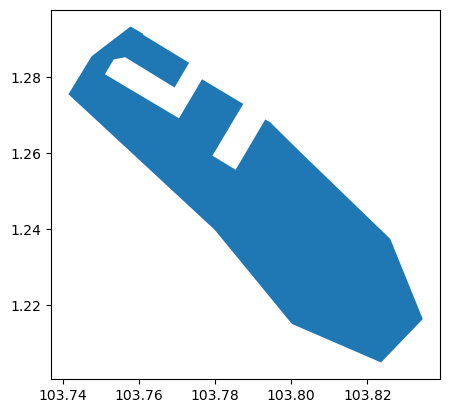

In [7]:
path = "/Users/luozeming/Desktop/1Hackathon/Category A (University Level) - NUS-RightShip Hackathon 2024/PPT_shapefiles/PPT_portboundary.shx"
port_boundary = gpd.read_file(path)
port_boundary.crs = {'init': 'epsg:4326'}

port_boundary.plot()

## location

In [8]:
path = "/Users/luozeming/Desktop/1Hackathon/Category A (University Level) - NUS-RightShip Hackathon 2024/vessel_movements/vessel_movements_PPT.csv"

gdf = pd.read_csv(path)
gdf = gpd.GeoDataFrame(gdf,geometry=gpd.points_from_xy(gdf.lon,gdf.lat))
gdf.crs = "EPSG:4326"


In [9]:
    
gdf['in_berth'] = gdf.geometry.apply(lambda x :berth_union.contains(x)).astype(int)

gdf['in_maneuver_zone'] = gdf.geometry.apply(lambda x :maneuver_zone.geometry.contains(x)).astype(int)

gdf['in_anchorage'] = gdf.geometry.apply(lambda x :anchorage.geometry.contains(x)).astype(int)

gdf['in_port_boundary'] = gdf.geometry.apply(lambda x :port_boundary.geometry.contains(x)).astype(int)

In [10]:
gdf.to_csv('./all.csv',index=False)

# df

In [3]:
df = pd.read_csv('./all.csv')

## Q1

In [4]:
def Q_1(df):
    '''
    location:
        1: berth
        2: maneuver_zone but outside berth
        3: anchorage
        4: the rest of port area
    '''
    ship_100k_df = df
    # we put 
    ship_100k_df['location'] = 0
    # "berth = true" and "berth = true, maneuver_zone = true" belong to 1 (berth)
    ship_100k_df.loc[ship_100k_df['in_berth'] == True, 'location'] = 1
    
    # 2: maneuver_zone include berth #but outside berth
    # "berth = False, maneuver_zone = true" belong to 2 (maneuver_zone)
    ship_100k_df.loc[(ship_100k_df['in_berth'] == False) & (ship_100k_df['in_maneuver_zone'] == True), 'location'] = 2

#      2: maneuver_zone include berth 
    # ship_100k_df.loc[(ship_100k_df['in_maneuver_zone'] == True), 'location'] = 2
    # "anchorage = true" belong to 3 (anchorage)
    ship_100k_df.loc[ship_100k_df['in_anchorage'] == True, 'location'] = 3
    
    # "berth = False" and "berth = False, maneuver_zone = False, port_boundary = True" belong to 4 (berth)
    ship_100k_df.loc[(ship_100k_df['in_berth'] == False) & 
                     (ship_100k_df['in_maneuver_zone'] == False) & 
                     (ship_100k_df['in_anchorage'] == False) & 
                     (ship_100k_df['in_port_boundary'] == True), 'location'] = 4
    return ship_100k_df

def Q_1_mode(df):
    """
    activity:
        1: transition
        2: anchorage
        3: maneuvering
        4: alomgside/hotel
    """
    
    # Initialize 'activity' column with default value of 0
    df['activity'] = 0
    
    # Transit: If speed > 1 OR navigational status = 0, 3, 4, 8, 11, 12
    # and it's OUTSIDE the maneuvering zone -->
    #(3) but inside the bigger port fence.
    transit_condition = ((df['speed'] > 1) | df['nav_stat'].isin([0, 3, 8, 4, 11, 12])) & (df['location'] != 1)& (df['location'] != 2)
    df.loc[transit_condition,'activity'] = 1

    #Anchorage: The vessel must be at an anchorage and non-moving (speed <1).
    anchorage_condition = ((df['speed'] < 1) & (df['location'] == 3))
    df.loc[anchorage_condition,'activity'] = 2
    
    # Maneuvering: If speed > 1 or navigational status = 0, 3, 4, 8, 11, 12
    # and it's INSIDE the maneuvering zone.
    maneuvering_condition = ((df['speed'] > 1) | df['nav_stat'].isin([0, 3, 8, 4, 11, 12])) & ((df['location'] == 1) | (df['location'] == 2))
    df.loc[maneuvering_condition, 'activity'] = 3
    
    
    # Alongside/Hotel: The vessel must be berthed (within a berth polygon) and speed < 1.
    alongside_condition = (df['speed'] < 1) & (df['location'] == 1)
    df.loc[alongside_condition, 'activity'] = 4
    
    return df

df = Q_1(df)
df = Q_1_mode(df)

## Q2

In [6]:
from datetime import timedelta

def Q_2(df):
    gdf = df
    gdf['timestamp'] = pd.to_datetime(gdf.timestamp)

    gdf['time_diff'] = gdf.sort_values(by=['imo','timestamp']).groupby('imo')['timestamp'].apply(lambda x:pd.Series(x).diff())

    # Create timedelta objects
    time_delta1 = timedelta(seconds=10000)
    # Assuming you want to check if the values in 'timestamp_diff' column are greater than 10000 seconds
    gdf['is_continuous'] = gdf['time_diff'] <= time_delta1

    # convert to hours
    gdf['time_diff'] = gdf['time_diff'] / pd.Timedelta(hours=1)


    gdf['valid_duration'] = gdf.is_continuous*gdf.time_diff
    # gdf.valid_mode.value_counts()

    gdf['valid_mode'] = gdf.is_continuous*gdf.activity
    return gdf
df = Q_2(df)

## Q3

In [8]:
def Q_3(df):
    vessel_movements_PPT_df = df
    vessel_movements_PPT_df['OGV'] = vessel_movements_PPT_df['group'].apply(lambda x: 'OGV' if x in ['Crude & Products Tanker', 'Offshore Support Vessel', 'Chemical Tanker', 'Container Ship', 'General Cargo','Passenger/Cruise', 'Bulk Carrier', 'Auto Carrier', 'Reefer', 'RoRo', 'LPG Tanker'] else 'Non-OGV')
    return vessel_movements_PPT_df
df = Q_3(df)

## Q4

In [9]:
def Q_4(df):

    vessel_movements_PPT_df = df
    vessel_movements_PPT_df['date_of_build'] = pd.to_datetime(vessel_movements_PPT_df['date_of_build'])
    conditions = [(vessel_movements_PPT_df['date_of_build'] >= pd.to_datetime('2000-01-01')),(vessel_movements_PPT_df['date_of_build'] >= pd.to_datetime('2011-01-01'))]


    # Define the bin edges
    bin_edges = [pd.to_datetime('1900-01-01'), pd.to_datetime('2000-01-01'), pd.to_datetime('2011-01-01'), pd.to_datetime('2100-01-01')]

    # Define the labels for the intervals
    labels = [0, 1, 2]

    # Create a new column 'Tier' based on the cut of 'date_of_build'
    vessel_movements_PPT_df['Tier'] = pd.cut(vessel_movements_PPT_df['date_of_build'], bins=bin_edges, labels=labels, include_lowest=True)


    vessel_movements_PPT_df.loc[vessel_movements_PPT_df['OGV'] == 'Non-OGV', 'Tier'] = np.nan

    return vessel_movements_PPT_df
df = Q_4(df)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822599 entries, 0 to 2822598
Data columns (total 48 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   imo                    int64              
 1   mmsi                   int64              
 2   vessel_id              int64              
 3   vessel_name            object             
 4   date_of_build          datetime64[ns]     
 5   vessel_type            object             
 6   group                  object             
 7   timestamp              datetime64[ns, UTC]
 8   date_only              object             
 9   lon                    float64            
 10  lat                    float64            
 11  nav_stat               int64              
 12  speed                  float64            
 13  course                 float64            
 14  heading                float64            
 15  fuel_category          int64              
 16  main_engine_fuel_t

# Total Electrical Load Analysis
Alongside or hotel load is the electrical load when the vessel is at the terminal/berth. In this mode the Main Engine is off since the Propulsion is not happening. Auxiliary Engines are running since they need to supply the electrical load for the ship and loading/discharging operating machineries.

Auxiliary Boilers produce steam and hence cannot be plugged into the electrical grid and there is no machinery onboard to generate steam.

Hence, for the purpose of this scope the Auxiliary engine load (column ael) in alongside mode will be used to identify the electrical load demand of the ships.

Total electrical demand from ship in alongside mode (Tael) = time-weighted average electrical load (ael) in alongside mode = (Sum of Product of Ael multiplied by alongside duration hours) divide by (Sum of total alongside duration in hours).



In [26]:
hotel.ael.isna()

247918

In [31]:
hotel.ael.fillna(0).isna().sum()

0

In [29]:
hotel.valid_duration.isna().sum()

0

In [32]:
hotel = df[df.valid_mode==4]
a1 = (hotel.ael.fillna(0) * hotel.valid_duration).sum()
b1 = hotel.valid_duration.sum()
Tael = a1/b1
Tael

757.638609896497

# Load demand variation from the grid through day and night on a monthly basis
For each “Alongside” operation mode, identify the time of the day as per below definition of Day and Night from timestamp column in vessel movements table.
- Day = 0900 to 1700 hours
- Night = 1700 to 0900 hours

Create visualizations to analyze the trends of the daily and monthly demand on the shore supply grid.
For DayEL and NightEL results, use the formula provided in previous section for the associated time description stated above.

NOTE: This day/ night demand can vary significantly depending on the weather and time of year in many parts of the world if not so much in Singapore. Example, winter may lead to smaller daylight time and hence more demand for vessel’s external lights to be on and vice versa.

In [11]:
# 根据条件生成 "Day" 和 "Night" 两个变量
df['period'] = df['timestamp'].apply(lambda x: 'Day' if 9 <= x.hour < 17 else 'Night')
df['date'] = df['timestamp'].apply(lambda x: x.date)
df['month'] = df['timestamp'].apply(lambda x: x.month)

df[['period','timestamp','date','month']].sample(10)

,period,timestamp,date,month
777263,Night,2023-09-14 07:16:02+00:00,2023-09-14,9
1209494,Night,2023-09-26 00:50:12+00:00,2023-09-26,9
1364511,Day,2023-09-19 11:25:06+00:00,2023-09-19,9
2351930,Day,2023-08-03 11:47:25+00:00,2023-08-03,8
505755,Night,2023-08-07 22:46:45+00:00,2023-08-07,8
2510794,Night,2023-08-10 18:20:37+00:00,2023-08-10,8
2026186,Day,2023-08-19 10:30:07+00:00,2023-08-19,8
2450908,Night,2023-08-01 19:55:01+00:00,2023-08-01,8
1045133,Night,2023-08-30 01:30:30+00:00,2023-08-30,8
295612,Night,2023-09-05 04:36:54+00:00,2023-09-05,9


In [33]:
def Tael_func(gdf):
    hotel = gdf[gdf.valid_mode==4]
    a1 = (hotel.ael.fillna(0) * hotel.valid_duration).sum()
    b1 = hotel.valid_duration.sum()
    Tael = a1/b1
    return Tael
result = df.groupby(["month",'date','period']).apply(Tael_func).reset_index()

In [34]:
result

,month,date,period,0
0,8,2023-08-01,Day,786.733123
1,8,2023-08-01,Night,783.763493
2,8,2023-08-02,Day,774.546164
3,8,2023-08-02,Night,738.169723
4,8,2023-08-03,Day,697.682896
...,...,...,...,...
117,9,2023-09-28,Night,777.941944
118,9,2023-09-29,Day,755.609523
119,9,2023-09-29,Night,794.195353
120,9,2023-09-30,Day,749.240618


In [37]:
df.groupby(['period']).apply(Tael_func).reset_index()

,period,0
0,Day,740.063838
1,Night,766.361156


In [36]:
result.groupby('period').agg([sum,np.mean])

month                       0            
         sum      mean           sum        mean
period                                          
Day      518  8.491803  39925.219764  739.355922
Night    518  8.491803  46404.036299  760.721907

In [19]:
result.to_csv('./Load demand variation .csv')

#  UniqueVessels


In [25]:
df.imo.nunique()

2778

# save

In [21]:
df.to_csv('./Q1234.csv',index=False)